In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

file_path = r"Vertex Capital Solutions\vertex_capital_data.xlsx"

df = pd.read_excel(file_path, sheet_name=0)
print(f"--- Successfully loaded '{file_path}' ---")


service_level_mapping = {
    'Low-Touch': 1,
    'Automated': 2,
    'High-Touch': 3
}
df['service_level_num'] = df['service_level_focus'].map(service_level_mapping)



app_ui_mapping = {
    'Functional': 1,
    'Modern': 2,
    'Sleek': 3
}
df['app_ui_num'] = df['app_ui_preference'].map(app_ui_mapping)


price_mapping = {
    'Low': 1,
    'Med': 2,
    'High': 3
}
df['price_sensitivity_num'] = df['price_sensitivity'].map(price_mapping)


df['profit'] = (df['annual_management_fee'] * (1 - (0.10 * df['referral_discount']))) - df['cost_of_service']

def categorize_service(service_tier):
    if 'Go' in service_tier:
        return 'Mainstream/Go'
    elif 'Bespoke' in service_tier or 'Private' in service_tier:
        return 'HNW/Bespoke'
    else:
        return 'Other'

df['service_category'] = df['service_tier'].apply(categorize_service)

print("\n--- All new columns created successfully. ---")
print("Here is a sample of the final prepared DataFrame:")
print(df[['service_tier', 'service_category', 'profit', 'service_level_num', 'price_sensitivity_num']].head())

print("\n--- Final Data .info() ---")
df.info()

--- Successfully loaded 'C:\Users\yashs\Desktop\Project\Vertex Capital Solutions\vertex_capital_data.xlsx' ---

--- Validating 'service_tier' (Our 'Product') ---
service_tier
Vertex Go (App)          3502
Vertex Go Plus (App)     2235
Vertex Bespoke           1106
Vertex Private Client     537
Name: count, dtype: int64

--- Validating 'service_level_focus' (Our 'Quality') ---
service_level_focus
Automated     5776
High-Touch    1339
Low-Touch      265
Name: count, dtype: int64

--- Validating 'app_ui_preference' (Our 'Aesthetics') ---
app_ui_preference
Modern    4699
Sleek     2681
Name: count, dtype: int64

--- Validating 'experiment_condition' (Our 'Marketing') ---
experiment_condition
Fin-Tok Influencer    3832
Forbes/WSJ Ads        2399
Control               1149
Name: count, dtype: int64

--- ValidCating 'referring_channel' ---
referring_channel
Search              1734
Social              1489
Email               1408
Direct              1062
AdvisorFinda.com     941
Affiliate   

--- Service Category Summary ---
  service_category  total_profit  total_clients  avg_profit_per_client  \
0      HNW/Bespoke     1340020.0           1643                 815.59   
1    Mainstream/Go      458667.4           5737                  79.95   

   avg_star_rating  
0             4.65  
1             3.98  


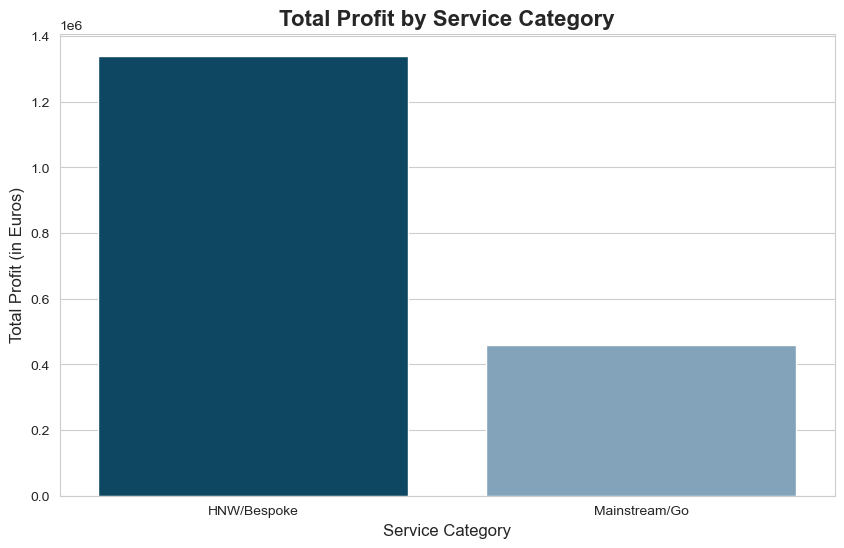

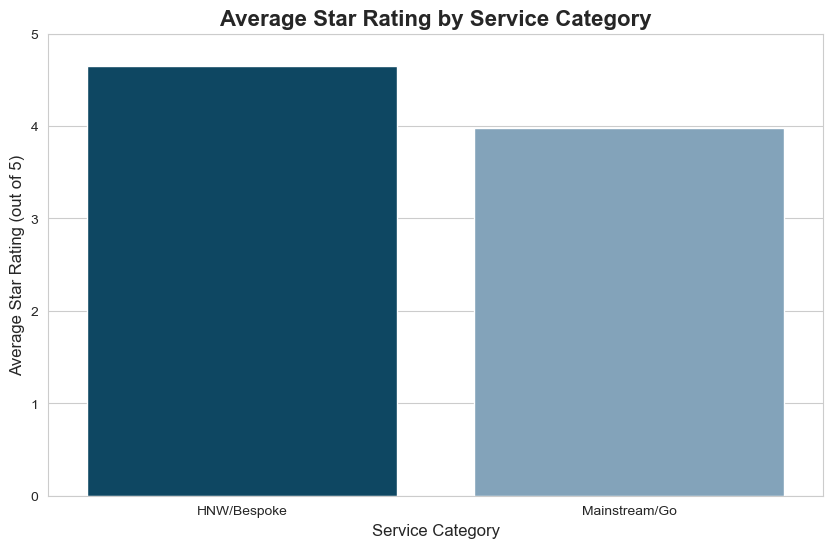

In [2]:
category_summary = df.groupby('service_category').agg(
    total_profit=('profit', 'sum'),
    total_clients=('transaction_id', 'count'),
    avg_profit_per_client=('profit', 'mean'),
    avg_star_rating=('review_star', 'mean')
).reset_index()

print("--- Service Category Summary ---")
print(category_summary.round(2))

sns.set_style("whitegrid")

# Plot 1: Total Profit by Service Category
plt.figure(figsize=(10, 6))
profit_plot = sns.barplot(
    data=category_summary,
    x='service_category',
    y='total_profit',
    palette=['#004c70', '#7aa5c3']
)
profit_plot.set_title('Total Profit by Service Category', fontsize=16, weight='bold')
profit_plot.set_xlabel('Service Category', fontsize=12)
profit_plot.set_ylabel('Total Profit (in Euros)', fontsize=12)
plt.show() 

# Plot 2: Average Star Rating by Service Category
plt.figure(figsize=(10, 6))
rating_plot = sns.barplot(
    data=category_summary,
    x='service_category',
    y='avg_star_rating',
    palette=['#004c70', '#7aa5c3']
)
rating_plot.set_title('Average Star Rating by Service Category', fontsize=16, weight='bold')
rating_plot.set_xlabel('Service Category', fontsize=12)
rating_plot.set_ylabel('Average Star Rating (out of 5)', fontsize=12)
rating_plot.set_ylim(0, 5) 
plt.show()

--- Data scaled and ready for clustering. ---
--- K-Means run for k=1 through 10. ---


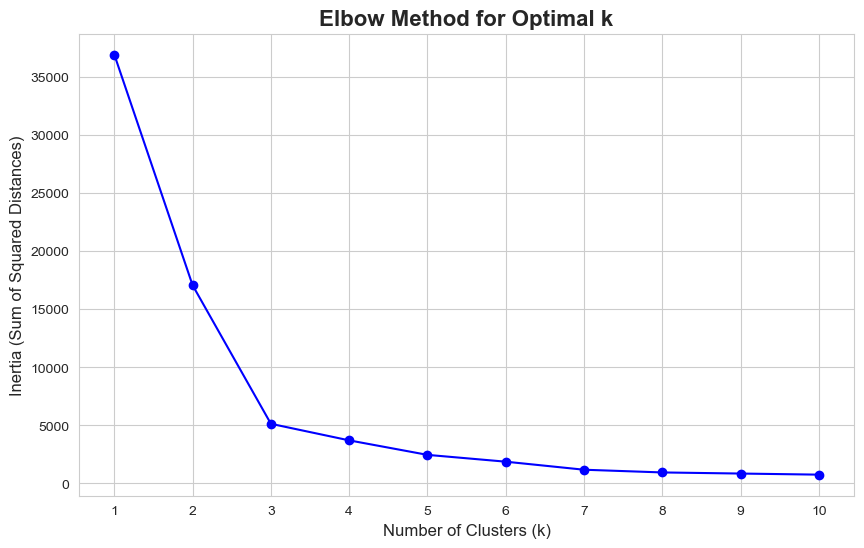

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features_for_clustering = [
    'avg_income',
    'service_level_num',
    'price_sensitivity_num',
    'brand_affinity_score',
    'churn_rate'
]

cluster_data = df[features_for_clustering].copy()

scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

print("--- Data scaled and ready for clustering. ---")


inertia_values = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(cluster_data_scaled)
    inertia_values.append(kmeans.inertia_) 

print("--- K-Means run for k=1 through 10. ---")

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, 'bo-')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=16, weight='bold')
plt.xticks(k_range)
plt.show()

In [4]:
k = 4
final_kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

final_kmeans.fit(cluster_data_scaled)

df['cluster'] = final_kmeans.labels_

print(f"--- 'cluster' column added to DataFrame with {k} segments. ---")

segment_profile = df.groupby('cluster').agg(
    total_clients=('transaction_id', 'count'),
    avg_income=('avg_income', 'mean'),
    avg_service_level=('service_level_num', 'mean'),
    avg_price_sensitivity=('price_sensitivity_num', 'mean'),
    avg_brand_affinity=('brand_affinity_score', 'mean'),
    avg_churn_rate=('churn_rate', 'mean'),
    avg_profit_per_client=('profit', 'mean'),
    avg_star_rating=('review_star', 'mean')
).reset_index()

service_preference = df.groupby(['cluster', 'service_category'])['transaction_id'].count().unstack(fill_value=0)

service_preference_pct = service_preference.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Customer Segment Profiles (Averages) ---")
print(segment_profile.round(2))
print("\n--- Service Purchase Preference (% of Sales) ---")
print(service_preference_pct.round(2))

full_segment_profile = pd.merge(segment_profile, service_preference_pct, on='cluster')

print("\n--- Full Segment Profile ---")
print(full_segment_profile.round(2))

print("\nFull segment profile saved to 'vertex_capital_segment_profile.csv'")

--- 'cluster' column added to DataFrame with 4 segments. ---

--- Customer Segment Profiles (Averages) ---
   cluster  total_clients  avg_income  avg_service_level  \
0        0           3463    48819.15               1.92   
1        1           2578    65617.38               2.00   
2        2           1026    85661.34               3.00   
3        3            313    66131.61               3.00   

   avg_price_sensitivity  avg_brand_affinity  avg_churn_rate  \
0                    3.0                2.99            0.18   
1                    2.0                3.87            0.08   
2                    1.0                4.55            0.22   
3                    2.0                3.94            0.08   

   avg_profit_per_client  avg_star_rating  
0                 120.45             3.96  
1                 224.63             4.20  
2                 706.43             4.52  
3                 248.21             4.24  

--- Service Purchase Preference (% of Sales) ---
s

--- Generating Segment Persona Bubble Chart ---


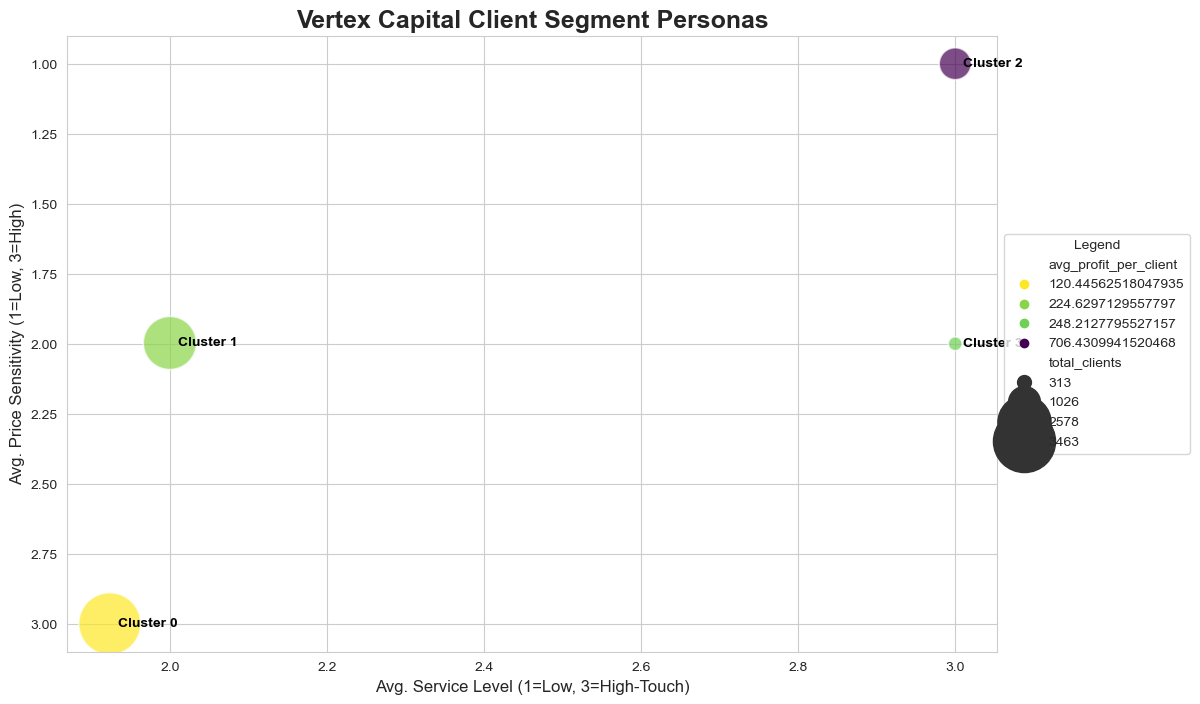


--- Persona Bubble Chart Saved as 'segment_persona_bubble_chart.png' ---


In [5]:
print("--- Generating Segment Persona Bubble Chart ---")

segment_profile_for_plot = full_segment_profile.copy()


plt.figure(figsize=(12, 8))

segment_plot = sns.scatterplot(
    data=segment_profile_for_plot,
    x='avg_service_level',
    y='avg_price_sensitivity',
    size='total_clients',
    hue='avg_profit_per_client',
    palette='viridis_r',
    sizes=(100, 2000),
    alpha=0.7,                   
    legend='full'
)


for i in range(segment_profile_for_plot.shape[0]):
    plt.text(
        x=segment_profile_for_plot['avg_service_level'][i] + 0.01,
        y=segment_profile_for_plot['avg_price_sensitivity'][i] + 0.01,
        s=f"Cluster {i}",
        fontdict=dict(color='black', size=10, weight='bold')
    )

segment_plot.set_title('Vertex Capital Client Segment Personas', fontsize=18, weight='bold')
segment_plot.set_xlabel('Avg. Service Level (1=Low, 3=High-Touch)', fontsize=12)
segment_plot.set_ylabel('Avg. Price Sensitivity (1=Low, 3=High)', fontsize=12)

plt.gca().invert_yaxis()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Legend")

plt.grid(True)
plt.show()

print("\n--- Persona Bubble Chart Saved as 'segment_persona_bubble_chart.png' ---")

--- Total Profit by Customer Segment ---
   cluster    profit
2        2  724798.2
1        1  579095.4
0        0  417103.2
3        3   77690.6


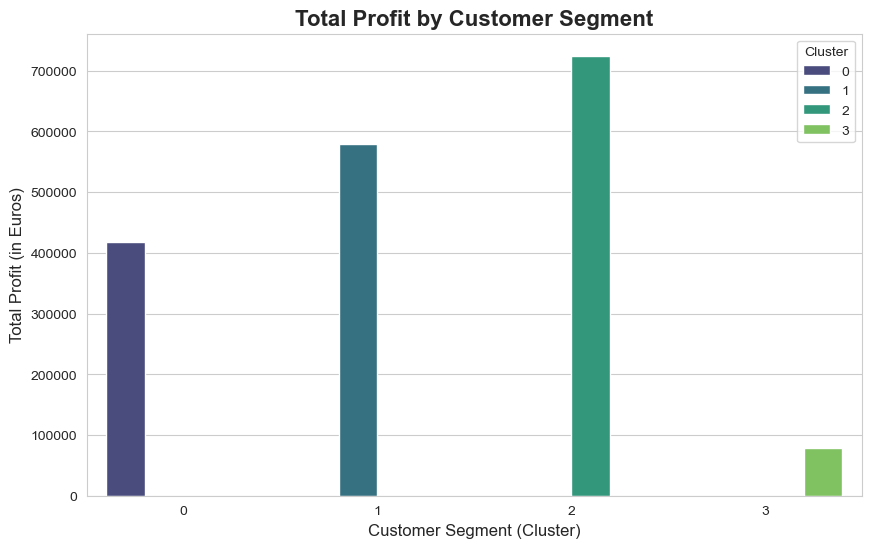


--- Marketing Experiment Analysis (% Customer Mix) ---
cluster                  0     1     2     3
experiment_condition                        
Control               0.42  0.26  0.28  0.03
Fin-Tok Influencer    0.50  0.40  0.05  0.05
Forbes/WSJ Ads        0.44  0.31  0.21  0.04

--- Referring Channel Analysis (% Customer Mix) ---
cluster               0     1     2     3
referring_channel                        
AdvisorFinda.com   0.21  0.32  0.43  0.03
Affiliate          0.37  0.32  0.27  0.04
Direct             0.38  0.40  0.17  0.05
Email              0.58  0.34  0.04  0.04
Search             0.53  0.36  0.07  0.04
Social             0.57  0.34  0.03  0.05


C:\Users\yashs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


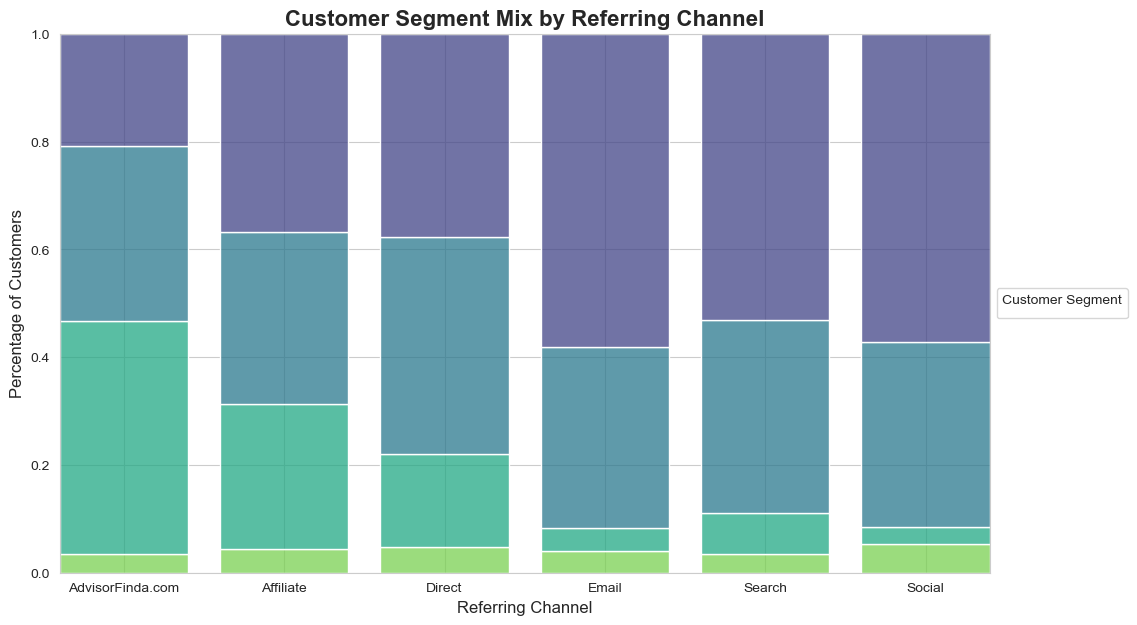

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

profit_by_segment = df.groupby('cluster')['profit'].sum().reset_index().sort_values('profit', ascending=False)

print("--- Total Profit by Customer Segment ---")
print(profit_by_segment.round(2))

plt.figure(figsize=(10, 6))

sns.barplot(
    data=profit_by_segment, 
    x='cluster', 
    y='profit', 
    palette='viridis',
    hue='cluster'
)
plt.title('Total Profit by Customer Segment', fontsize=16, weight='bold')
plt.xlabel('Customer Segment (Cluster)', fontsize=12)
plt.ylabel('Total Profit (in Euros)', fontsize=12)
plt.legend(title='Cluster')
plt.show()

experiment_analysis = df.groupby(['experiment_condition', 'cluster'])['transaction_id'].count().unstack(fill_value=0)
experiment_analysis_pct = experiment_analysis.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Marketing Experiment Analysis (% Customer Mix) ---")
print(experiment_analysis_pct.round(2))

channel_analysis = df.groupby(['referring_channel', 'cluster'])['transaction_id'].count().unstack(fill_value=0)
channel_analysis_pct = channel_analysis.apply(lambda x: x / x.sum(), axis=1)

print("\n--- Referring Channel Analysis (% Customer Mix) ---")
print(channel_analysis_pct.round(2))

channel_plot_data = channel_analysis_pct.reset_index().melt(
    id_vars='referring_channel', 
    var_name='cluster', 
    value_name='percentage'
)

channel_plot_data['cluster'] = channel_plot_data['cluster'].astype(str)

plt.figure(figsize=(12, 7))
sns.histplot(
    data=channel_plot_data,
    x='referring_channel',
    hue='cluster',
    weights='percentage', 
    multiple='fill',
    palette='viridis',   
    shrink=0.8
)

plt.title('Customer Segment Mix by Referring Channel', fontsize=16, weight='bold')
plt.xlabel('Referring Channel', fontsize=12)
plt.ylabel('Percentage of Customers', fontsize=12)
plt.legend(title='Customer Segment', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

C:\Users\yashs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


--- Data prepared for plotting. ---


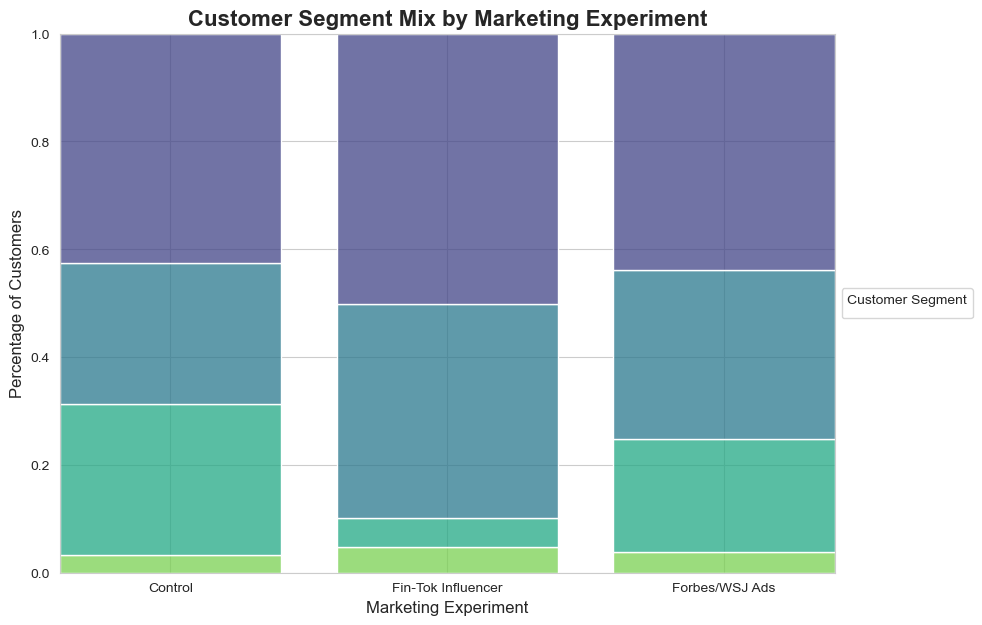

--- 'experiment_segment_mix.png' saved. ---


In [11]:
experiment_plot_data = experiment_analysis_pct.reset_index().melt(
    id_vars='experiment_condition', 
    var_name='cluster', 
    value_name='percentage'
)

experiment_plot_data['cluster'] = experiment_plot_data['cluster'].astype(str)

print("--- Data prepared for plotting. ---")

plt.figure(figsize=(10, 7))
sns.histplot(
    data=experiment_plot_data,
    x='experiment_condition',
    hue='cluster',
    weights='percentage',
    multiple='fill',
    palette='viridis',
    shrink=0.8
)

plt.title('Customer Segment Mix by Marketing Experiment', fontsize=16, weight='bold')
plt.xlabel('Marketing Experiment', fontsize=12)
plt.ylabel('Percentage of Customers', fontsize=12)
plt.legend(title='Customer Segment', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("--- 'experiment_segment_mix.png' saved. ---")

In [10]:
reviews_df = df.dropna(subset=['review_text'])

print(f"--- Analyzing {len(reviews_df)} total client reviews ---")

influencer_go_reviews = reviews_df[
    (reviews_df['experiment_condition'] == 'Fin-Tok Influencer') &
    (reviews_df['service_category'] == 'Mainstream/Go')
]

advisor_hnw_reviews = reviews_df[
    (reviews_df['referring_channel'] == 'AdvisorFinda.com') &
    (reviews_df['service_category'] == 'HNW/Bespoke')
]


print("   REVIEW BREAKDOWN: 'FIN-TOK INFLUENCER' / 'MAINSTREAM/GO' APP")
print(influencer_go_reviews['review_text'].value_counts())


print("   REVIEW BREAKDOWN: 'ADVISORFINDA.COM' / 'HNW/BESPOKE' SERVICE")

print(advisor_hnw_reviews['review_text'].value_counts())

--- Analyzing 2827 total client reviews ---

   REVIEW BREAKDOWN: 'FIN-TOK INFLUENCER' / 'MAINSTREAM/GO' APP
review_text
The app UI and auto-deposit are fantastic; a perfect starter                          207
Great starter app—simple, convenient, and looks modern.                               185
Easy setup and decent returns; wish the app had more research tools.                  182
Loved the simple UI and easy-to-use controls; good value.                             181
The app is very simple; it's fine for my weekly $50 deposit.                          177
Good value for a free app; looks sleek and gets the job done.                         155
Returns are flat and diversification is narrow; below expectations for this brand.      8
The robo-advisor is fine, but the fund quality and returns fall short.                  3
Portfolio is all high-fee funds with no clear strategy; lacks clarity.                  3
Name: count, dtype: int64

   REVIEW BREAKDOWN: 'ADVISORFINDA.COM' / 